In [13]:
import copy
import cv2
import joblib
import math
import matplotlib.pyplot as plt
import numpy as np
import time
from tensorflow import keras
import xml.etree.ElementTree as ET

In [14]:
def image_names_parser(path):
    tree = ET.parse(f'{path}/annotations.xml')
    root = tree.getroot()
    image_names = []
    for image in root.findall('image'):
        image_names.append(image.get('name'))
    return image_names

def labels_parser(path, image_name):
    tree = ET.parse(f'{path}/annotations.xml')
    root = tree.getroot()

    labels = {}
    for i, label in enumerate(root.iter('label')):
        labels[label.find('name').text] = i

    image_node = None
    for image in root.findall('image'):
        if image.get('name') == image_name:
            image_node = image

    boxs = []
    coordinates = ['ytl', 'xtl', 'ybr', 'xbr']
    for i in range(len(labels)):
        boxs.append([])
    for box in image_node.findall('box'):
        points = []
        for coordinate in coordinates:
            points.append(int(box.get(coordinate).split(".")[0]))
        boxs[labels[box.get('label')]].append(points)

    return boxs

In [15]:
def check_out_of_box(sliding_window, box):
    if sliding_window[2] < box[0] or sliding_window[0] > box[2]:
        return True
    if sliding_window[3] < box[1] or sliding_window[1] > box[3]:
        return True
    return False

def check_box(sliding_window, box, overlapping):
    if check_out_of_box(sliding_window, box):
        return False
    
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    overlap_area = (min(sliding_window[2], box[2]) - max(sliding_window[0], box[0])) * (min(sliding_window[3], box[3]) - max(sliding_window[1], box[1]))
    if overlap_area / box_area < overlapping:
        return False    
    
    return True

In [16]:
def label_voting(validate_result, threshold, image_shape, sliding_window_size, step, image_start):
    height = math.ceil((image_shape[0] - sliding_window_size - image_start[0]) / step)
    width = math.ceil((image_shape[1] - sliding_window_size - image_start[1]) / step)
    print(image_shape)
    print([height, width])
    voting = np.zeros((height + 4, width + 4))
    total = np.zeros((height + 4, width + 4))

    for j in range(height):
        for i in range(width):
            p = validate_result[i + j * width, 1]
            voting[j : j + 5, i : i + 5] += np.ones((5, 5)) * p
            total[j : j + 5, i : i + 5] += np.ones((5, 5))
    voting /= total
    voting = np.where(voting > threshold, 1, 0)
    return voting

In [17]:
model_name = "saved_model/hyperbola_vgg2.keras"
model = keras.models.load_model(model_name, compile = False)
model.compile()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 200, 32)      832       
                                                                 
 dropout_6 (Dropout)         (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      51264     
                                                                 
 dropout_7 (Dropout)         (None, 100, 100, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                  

In [18]:
start_time = time.time()
IMAGE_START = 64
AXIS_ZERO = 121     # 1st dataset, 2nd dataset: 121, 3rd dataset: 44

image_name = "WLT_350_210926 P_2111131 WLT_350_210926__022 P_2111131.JPG"
image_path = f"../data_preprocessing/unprocessed_images/{image_name}"

sliding_window_size = 200
step = 40
img = cv2.imread(image_path)

# scale down
scale_percent = 50 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
IMAGE_START = int(IMAGE_START * scale_percent / 100)
AXIS_ZERO = int(AXIS_ZERO * scale_percent / 100)
image_start = [AXIS_ZERO, IMAGE_START]

height = math.ceil((img.shape[0] - sliding_window_size - image_start[0]) / step)
width = math.ceil((img.shape[1] - sliding_window_size - image_start[1]) / step)
number_image = height * width

In [19]:
def validate_label(image, voting, scale_percent, image_name, file_name='output.jpg'):
    img = copy.deepcopy(image)
    label_path = '../data_preprocessing/1stdataset20230420' # 1st dataset
    # label_path = '../data_preprocessing/2ndDataset20230421' # 2nd dataset
    # label_path = '../data_preprocessing/3rdDataset20230420' # 3rd dataset
    labels = labels_parser(label_path, image_name.replace('.JPG', '_processed.JPG'))

    print(f'evaluating {image_name}...')
    feature_types = ['small strong hyperbola', 'small weak hyperbola', 'noise', 'large strong hyperbola', 'large weak hyberbola', 'no feature']
    image_shape = img.shape
    height = math.ceil((image_shape[0] - sliding_window_size - image_start[0]) / step)
    width = math.ceil((image_shape[1] - sliding_window_size - image_start[1]) / step)

    print(voting.shape)
    no_feature_index = len(feature_types) - 1
    label_check = np.zeros(len(feature_types))
    
    hyperbola_feature = [0, 1, 3, 4]
    for k in hyperbola_feature:
        for box in labels[k]:
            box_index = []
            for i, b in enumerate(box):
                if i % 2 == 0:
                    box_index.append((b * scale_percent / 100 - image_start[0]) / step)
                else:
                    box_index.append((b * scale_percent / 100 - image_start[1]) / step)
            start = [math.floor(box_index[0]), math.floor(box_index[1])]
            end = [math.ceil(box_index[2] + 1), math.ceil(box_index[3] + 1)]
            is_feature = False
            for j in range(max(start[0], 0), min(end[0] + 4, height)):
                for i in range(max(start[1], 0), min(end[1] + 4, width)):
                    if voting[j, i] == 1 and not check_out_of_box([j, i, j + 1, i + 1], box_index):
                        voting[j, i] = 2
                        is_feature = True
            if is_feature:
                label_check[k] += 1

        print(f'{feature_types[k]} accuracy: {int(label_check[k])} / {len(labels[k])}')

    precision = 0
    total = 0
    for j in range(height + 4):
        for i in range(width + 4):
            if voting[j, i] > 0:
                total += 1
                if voting[j, i] == 2:
                    precision += 1
    if (total == 0):
        print('area precision not available')
    else:
        print(f'area precision: {precision / total:.4f}')

    box_width = 2
    for j in range(height + 4):
        for i in range(width + 4):
            box = [image_start[1] + i * step, image_start[0] + j * step, image_start[1] + (i + 1) * step, image_start[0] + (j + 1) * step]
            if voting[j, i] == 1:
                color = np.array([229, 0, 0]) # red
            elif voting[j, i] == 2:
                color = np.array([3, 67, 223])
                color = np.array([21, 176, 26]) # green

            if voting[j, i] > 0:
                img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :] = np.ones_like(img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :]) * color
                img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :] = np.ones_like(img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :]) * color
                img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :] = np.ones_like(img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :]) * color
                img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :] = np.ones_like(img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :]) * color
    plt.imshow(img)
    plt.imsave(file_name, img)

In [20]:
count = 0
sub_images = np.zeros(shape=(number_image, 200, 200), dtype='float32')

for j in range(height):
    for i in range(width):
        sliding_window = [image_start[0] + j * step, image_start[1] + i * step, image_start[0] + sliding_window_size + j * step, image_start[1] + sliding_window_size + i * step]
        sub_img = img[sliding_window[0]:sliding_window[2], sliding_window[1]:sliding_window[3]]
        rgb_weights = [0.2990, 0.5870, 0.1140]
        sub_img = np.dot(sub_img[...,:3], rgb_weights)
        sub_img = np.array(sub_img)

        sub_images[count] = sub_img / 255
        count += 1
        
print(sub_images.shape)

(414, 200, 200)


In [21]:
validate_result = model.predict(sub_images)
print(validate_result.shape)

13/13 [==============================] - 9s 716ms/step
(414, 2)


(603, 2053, 3)
[9, 46]
evaluating WLT_350_210926 P_2111131 WLT_350_210926__022 P_2111131.JPG...
(13, 50)
small strong hyperbola accuracy: 0 / 2
small weak hyperbola accuracy: 0 / 5
large strong hyperbola accuracy: 0 / 0
large weak hyberbola accuracy: 0 / 0
area precision not available
execution time: 10.8447 seconds
image size: (603, 2053)


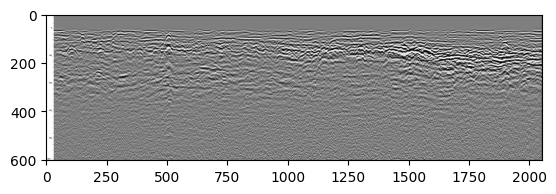

In [22]:
voting = label_voting(validate_result, 0.5, img.shape, sliding_window_size, step, [AXIS_ZERO, IMAGE_START])
validate_label(img, voting, scale_percent, image_name, file_name='validation_CNN.jpg')
print(f'execution time: {time.time() - start_time:.4f} seconds')
print(f'image size: {(img.shape[0], img.shape[1])}')

In [23]:
def validate_label_video(image, voting, file_name='output.mp4'):
    img = copy.deepcopy(image)
    print('recording video...')
    image_shape = img.shape
    height = math.ceil((image_shape[0] - sliding_window_size - image_start[0]) / step)
    width = math.ceil((image_shape[1] - sliding_window_size - image_start[1]) / step)
    video_writer = cv2.VideoWriter(file_name, cv2.VideoWriter_fourcc(*'MP4V'), 30, (image_shape[1], image_shape[0]))
    voting_i = 0
    box_width = 2
    for i in range(image_start[1], image_shape[1], 5):
        video_color = np.array([223, 67, 3]) # blue
        img[:, i - 6:i - 3, :] = image[:, i - 6:i - 3, :]
        img[:, i - 1:i + 2, :] = np.ones_like(img[:, i - 1:i + 2, :]) * video_color
        if i > image_start[1] + (voting_i + 1) * step:
            for voting_j in range(height + 4):
                box = [image_start[1] + voting_i * step, image_start[0] + voting_j * step, image_start[1] + (voting_i + 1) * step, image_start[0] + (voting_j + 1) * step]
                if voting[voting_j, voting_i] > 0:
                    if voting[voting_j, voting_i] == 1:
                        video_color = np.array([0, 0, 229]) # red
                    elif voting[voting_j, voting_i] == 2:
                        video_color = np.array([26, 176, 21]) # green

                    img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :] = np.ones_like(img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :]) * video_color
                    img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :] = np.ones_like(img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :]) * video_color
                    img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :] = np.ones_like(img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :]) * video_color
                    img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :] = np.ones_like(img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :]) * video_color
            voting_i += 1
        video_writer.write(img)

    video_writer.release()
    cv2.destroyAllWindows()
    print('video saved')

In [24]:
validate_label_video(img, voting, file_name='validation_CNN.mp4')

recording video...
video saved
